* 변경 내용 : 기존의 모델에서 기온을 넣어서 예측함.

# 1. 모듈 임포트

In [1]:
import numpy as np
import pandas as pd

import calendar

from sklearn.linear_model import Ridge, Lasso

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
from pylab import *

plt.rc('font', family = 'Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

import warnings
warnings.filterwarnings(action = 'ignore')


# 2. 데이터 불러오기

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

# 3. Function

점심식사가 가능한 사람들은 본사정원수에서 휴가자수, 재택근무자수를 제외한 나머지이다.

In [3]:
def prep(df) :
    df['일자'] = df.일자.apply(lambda x : pd.to_datetime(x))
    df['year'] = df.일자.apply(lambda x : x.year)
    df['month'] = df.일자.apply(lambda x : x.month)
    df['day'] = df.일자.apply(lambda x : x.day)
    df['요일'] = df.일자.apply(lambda x : x.weekday())
    df[['mon','tue','wed','thu','fri']] = pd.get_dummies(df['요일'])
    df['점심식사가능자수'] = df['본사정원수'] - df['본사휴가자수'] - df['현본사소속재택근무자수']
    return df

In [4]:
prep(train)
prep(test).head(3)

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,year,month,day,mon,tue,wed,thu,fri,점심식사가능자수
0,2021-01-27,2,2983,88,182,5,358.0,모닝롤/연유버터베이글 우유/주스 계란후라이/찐계란 단호박죽/흑미밥 우거지국 고기완자...,쌀밥/흑미밥/찰현미밥 대구지리 매운돈갈비찜 오꼬노미계란말이 상추무침 포기김치 양상추...,흑미밥 얼큰순두부찌개 쇠고기우엉볶음 버섯햄볶음 (New)아삭이고추무절임 포기김치,2021,1,27,0,0,1,0,0,2537.0
1,2021-01-28,3,2983,104,212,409,348.0,모닝롤/대만샌드위치 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 황태국 시래기지짐 ...,쌀밥/보리밥/찰현미밥 우렁된장찌개 오리주물럭 청양부추전 수제삼색무쌈 겉절이김치 양상...,충무김밥 우동국물 오징어무침 꽃맛살샐러드 얼갈이쌈장무침 석박지,2021,1,28,0,0,0,1,0,2531.0
2,2021-01-29,4,2983,270,249,0,294.0,모닝롤/핫케익 우유/주스 계란후라이/찐계란 오곡죽/흑미밥 매생이굴국 고구마순볶음 양...,쌀밥/흑미밥/찰현미밥 팽이장국 수제돈까스*소스 가자미조림 동초나물무침 포기김치 양상...,흑미밥 물만둣국 카레찜닭 숯불양념꼬지어묵 꼬시래기무침 포기김치,2021,1,29,0,0,0,0,1,2419.0


# 4. 간단한 EDA

각 변수들의 분포를 알아보자.

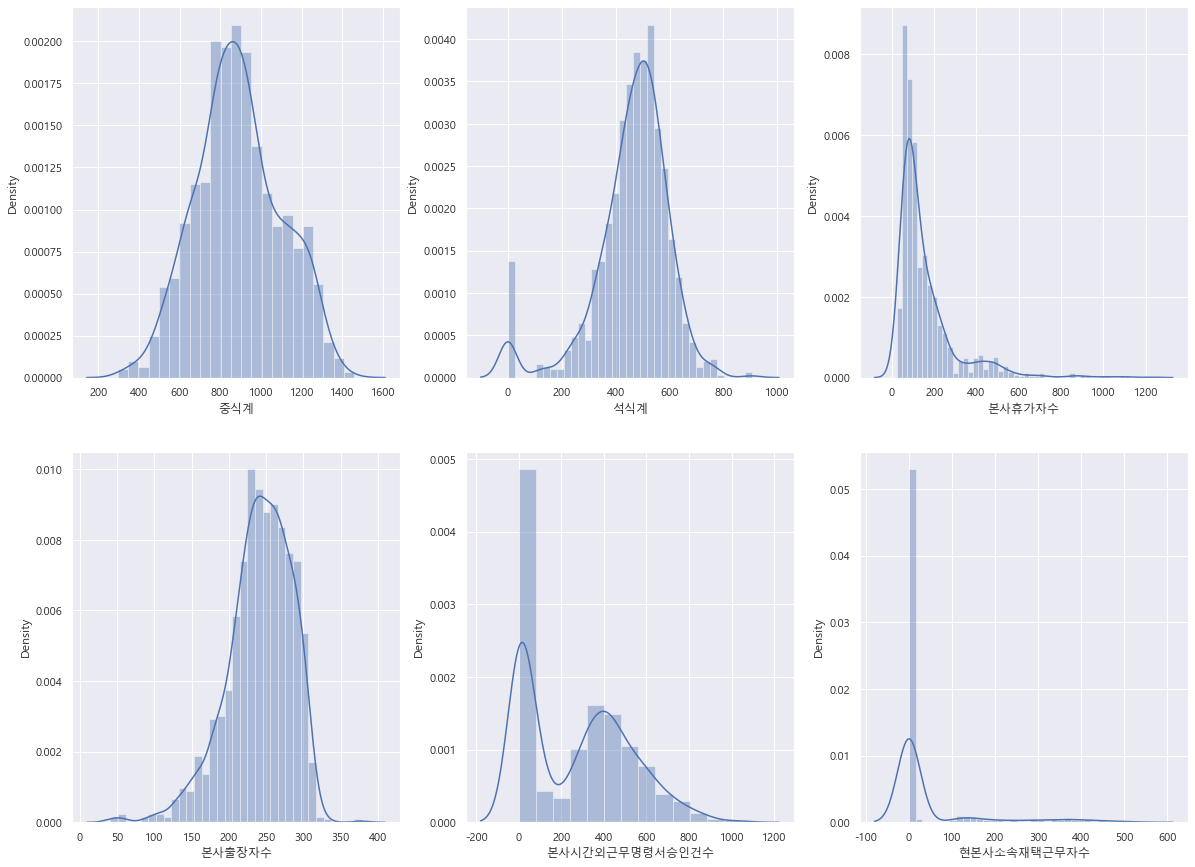

In [5]:
sns.set(rc={"figure.figsize": (20, 15)})

plt.rc('font', family='Malgun Gothic') 
plt.rcParams['axes.unicode_minus'] = False 

subplot(2,3,1)
ax = sns.distplot(train['중식계'])

subplot(2,3,2)
ax = sns.distplot(train['석식계'])

subplot(2,3,3)
ax = sns.distplot(train['본사휴가자수'])

subplot(2,3,4)
ax = sns.distplot(train['본사출장자수'])

subplot(2,3,5)
ax = sns.distplot(train['본사시간외근무명령서승인건수'])

subplot(2,3,6)
ax = sns.distplot(train['현본사소속재택근무자수'])


plt.show()

우리가 구해야 하는 중식계, 석식계의 분포를 확인해보면 정규분포의 형태에 거의 가깝다.   
따라서 중식계, 석식계 데이터는 더이상 가공하지 않기로 한다.

In [6]:
weekday_df = train.groupby('요일').sum()
year_df = train.groupby(['year', 'month']).sum()
year_df.head()

요일  본사정원수  본사휴가자수  본사출장자수  본사시간외근무명령서승인건수  현본사소속재택근무자수      중식계  \
year month                                                                    
2016 2      37  46818    2765    3782            4457          0.0  17422.0   
     3      45  57728    1405    5046            4873          0.0  21169.0   
     4      42  52860    1563    4946            4150          0.0  17875.0   
     5      34  52700    1794    5018            4184          0.0  18868.0   
     6      45  55377    1913    5282            4185          0.0  19588.0   

                석식계  day  mon  tue  wed  thu  fri  점심식사가능자수  
year month                                                   
2016 2       9565.0  272    4    3    3    4    4   44053.0  
     3      12236.0  367    4    4    5    5    4   56323.0  
     4      10665.0  318    4    4    3    4    5   51297.0  
     5      10694.0  340    5    5    4    3    3   50906.0  
     6      11228.0  339    3    4    5    5    4   53464.0

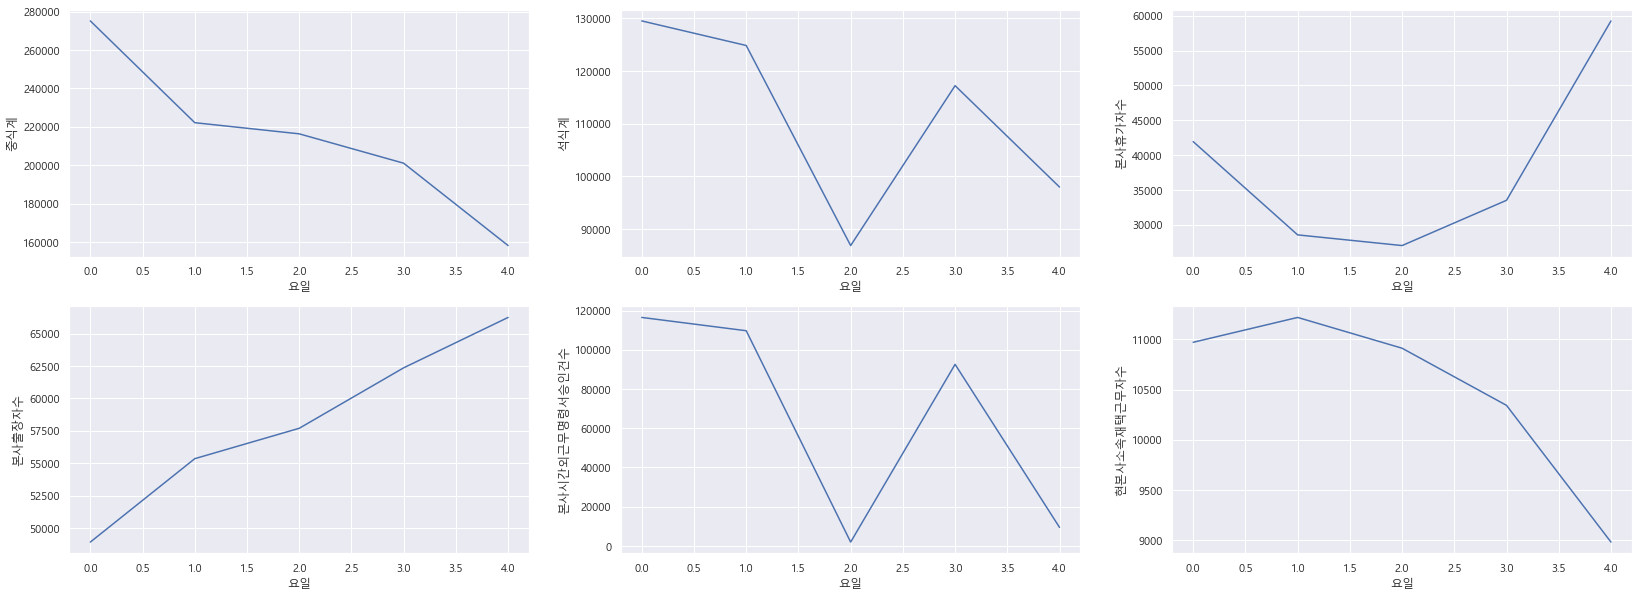

In [7]:
# 요일에 따른 각 변수의 분포를 확인해보자.

sns.set(rc={"figure.figsize": (28, 10)})

plt.rc('font', family='Malgun Gothic') 
plt.rcParams['axes.unicode_minus'] = False 

subplot(2,3,1)
sns.lineplot(data = weekday_df, x = weekday_df.index, y = '중식계')

subplot(2,3,2)
sns.lineplot(data = weekday_df, x = weekday_df.index, y = '석식계')

subplot(2,3,3)
sns.lineplot(data = weekday_df, x = weekday_df.index, y = '본사휴가자수')

subplot(2,3,4)
sns.lineplot(data = weekday_df, x = weekday_df.index, y = '본사출장자수')

subplot(2,3,5)
sns.lineplot(data = weekday_df, x = weekday_df.index, y = '본사시간외근무명령서승인건수')

subplot(2,3,6)
sns.lineplot(data = weekday_df, x = weekday_df.index, y = '현본사소속재택근무자수')

plt.show()

* 휴가자수는 금요일에 가장 많다.
* 출장자수는 월~금요일로 갈 수록 많아진다.
* 월요일이 야근이 가장 많은 듯하다.
* 재택근무자수는 최근 2020년부터 생겼는데, 금요일이 가장 적다.

* 재택근무자수는 0이 너무 많으므로 제외한다.

In [8]:
# 휴가자수, 재택근무자수는 '점심식사가능자수'에서 계산했으므로 제외한 나머지 변수들을 훈련시킨다.
# 점심, 저녁을 따로 구해야 하므로 점심데이터를 1, 저녁을 2로 나눈다. 

x1_cols = ['month', 'day', '요일', '본사출장자수', '본사시간외근무명령서승인건수', '점심식사가능자수']
x2_cols = ['month', 'day', '요일',  '본사출장자수', '본사시간외근무명령서승인건수','점심식사가능자수']

y1_col = ['중식계']
y2_col = ['석식계']

x1_train = train[x1_cols]
x2_train = train[x2_cols]


y1_train = train[y1_col]
y2_train = train[y2_col]

In [9]:
# test.csv 에서 들고온 최종 예측해야 하는 데이터 세트(test set)
x1_test = test[x1_cols]
x2_test = test[x2_cols]

In [10]:
# 석식계는 수요가 많은 날 순서대로 매핑(가장 많은게 1, 가장 적은게 5)
요일_석식_map = {0 : 1,
             1 : 2,
             2 : 5, 
             3 : 3,
             4 : 4}

In [11]:
x2_train['요일'] = x2_train['요일'].map(요일_석식_map)
x2_test['요일'] = x2_test['요일'].map(요일_석식_map)

### [최고의 파라미터 찾는 함수]

In [12]:
def find_best_params(model, params, x, y):
    grid = GridSearchCV(model, param_grid=params, 
                        scoring='neg_mean_absolute_error', verbose = 1)
    grid.fit(x, y)
    best = np.round(abs(grid.best_score_), 2)
    grid_model = grid.best_estimator_
    print('{} 일 때 최적 평균 MAE 값 : {}, 최적 Parameters : {}'.format(model.__class__.__name__, best, grid.best_params_))
    return grid_model

# [ML training]

### 1. Xgboost Regressor  
xgboost Regressor로 훈련시켜보자.

In [13]:
xgb1_model = XGBRegressor(random_state = 42)
xgb2_model = XGBRegressor(random_state = 42)
xgb1_grid = {'learning_rate' : [0.01, 0.1, 0.09, 0.089, 0.08], 'booster' : ['gbtree', 'gblinear', 'dart']}
xgb2_grid = {'learning_rate' : [0.01, 0.1, 0.09, 0.089, 0.08], 'booster' : ['gbtree', 'gblindear', 'dart']}

xgb1_model = find_best_params(xgb1_model, xgb1_grid, x1_train, y1_train)
xgb2_model = find_best_params(xgb2_model, xgb2_grid, x2_train, y2_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
XGBRegressor 일 때 최적 평균 MAE 값 : 88.12, 최적 Parameters : {'booster': 'dart', 'learning_rate': 0.08}
Fitting 5 folds for each of 15 candidates, totalling 75 fits
XGBRegressor 일 때 최적 평균 MAE 값 : 74.95, 최적 Parameters : {'booster': 'gbtree', 'learning_rate': 0.08}


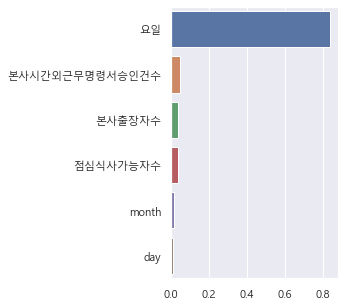

In [14]:
# 점심 feature importance 확인
plt.figure(figsize = (3, 5))
co1 = pd.Series(xgb1_model.feature_importances_, index = x1_train.columns)
co_sort1 = co1.sort_values(ascending = False)
sns.barplot(x = co_sort1.values, y = co_sort1.index)
plt.show()

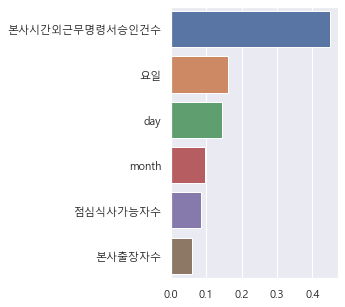

In [15]:
# 저녁 feature importance 확인
plt.figure(figsize = (3, 5))
co2 = pd.Series(xgb2_model.feature_importances_, index = x2_train.columns)
co_sort2 = co2.sort_values(ascending = False)
sns.barplot(x = co_sort2.values, y = co_sort2.index)
plt.show()

### 2. LGBM Regressor  
LightGBM Regressor로 훈련시켜보자.

In [16]:
lgb1_model = LGBMRegressor()
lgb2_model = LGBMRegressor()
lgb1_grid = {'learning_rate' : [0.01, 0.1, 0.09, 0.089, 0.08]}
lgb2_grid = {'learning_rate' : [0.01, 0.1, 0.09, 0.089, 0.08]}

lgb1_model = find_best_params(lgb1_model, lgb1_grid, x1_train, y1_train)
lgb2_model = find_best_params(lgb2_model, lgb2_grid, x2_train, y2_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
LGBMRegressor 일 때 최적 평균 MAE 값 : 88.81, 최적 Parameters : {'learning_rate': 0.09}
Fitting 5 folds for each of 5 candidates, totalling 25 fits
LGBMRegressor 일 때 최적 평균 MAE 값 : 77.51, 최적 Parameters : {'learning_rate': 0.08}


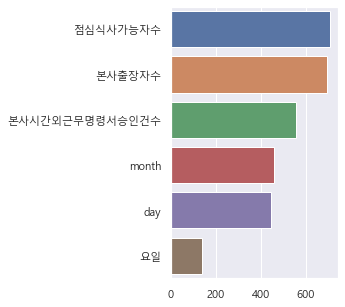

In [17]:
# 점심 feature importance 확인
plt.figure(figsize = (3, 5))
co1 = pd.Series(lgb1_model.feature_importances_, index = x1_train.columns)
co_sort1 = co1.sort_values(ascending = False)
sns.barplot(x = co_sort1.values, y = co_sort1.index)
plt.show()

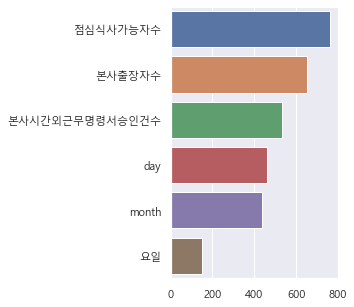

In [18]:
# 저녁 feature importance 확인
plt.figure(figsize = (3, 5))
co2 = pd.Series(lgb2_model.feature_importances_, index = x2_train.columns)
co_sort2 = co2.sort_values(ascending = False)
sns.barplot(x = co_sort2.values, y = co_sort2.index)
plt.show()

* 70.2233 (7/8 목요일 50등)

# [기온 변수 추가]

생각보다 성능이 안좋아서 다른 변수도 추가해보기로 했다.  
한국토지주택공사는 진주시에 있으므로 진주시의 기후 데이터를 KOSIS에서 가지고 온다.

In [19]:
temp = pd.read_csv('진주시 기온.csv', encoding = 'cp949')
rain = pd.read_csv('진주시 강수량.csv', encoding = 'cp949')

temp['일시'] = temp.일시.apply(pd.to_datetime)
rain['일시'] = rain.일시.apply(pd.to_datetime)

temp.index[temp.isna().all(axis=1)]
temp.fillna(method='bfill', inplace = True)

### [훈련데이터와 기후 데이터를 합치는 Function]

In [20]:
def thing_merge(df1, df2, col1, col2, drop_col):
    new_df = pd.merge(df1, df2, left_on = col1, right_on = col2, how = 'inner')
    new_df.drop(drop_col, axis = 1, inplace = True)
    return new_df

In [21]:
# train, test 데이터에 기후 데이터 합치기

train_temp_mg = thing_merge(train, temp, '일자', '일시', '일시')
train_temp_rain_mg = thing_merge(train_temp_mg, rain, '일자', '일시', ['일시', '1시간최다강수량(mm)', '1시간최다강수량시각'])

test_temp_mg = thing_merge(test, temp, '일자', '일시', '일시')
test_temp_rain_mg = thing_merge(test_temp_mg, rain, '일자', '일시', ['일시', '1시간최다강수량(mm)', '1시간최다강수량시각'])

In [22]:
x1_cols = ['month', 'day', '요일', '본사출장자수', '본사시간외근무명령서승인건수', '점심식사가능자수', '평균기온(℃)']
x2_cols = ['month', 'day', '요일',  '본사출장자수', '본사시간외근무명령서승인건수','점심식사가능자수', '평균기온(℃)']

y1_col = ['중식계']
y2_col = ['석식계']

x1_train = train_temp_rain_mg[x1_cols]
x2_train = train_temp_rain_mg[x2_cols]

y1_train = train_temp_rain_mg[y1_col]
y2_train = train_temp_rain_mg[y2_col]

x1_test = test_temp_rain_mg[x1_cols]
x2_test = test_temp_rain_mg[x2_cols]

### [기온 넣어서 예측]

#### 1.xgb

In [23]:
xgb1_model = XGBRegressor(random_state = 42)
xgb2_model = XGBRegressor(random_state = 42)
xgb1_grid = {'learning_rate' : [0.01, 0.1, 0.09, 0.089, 0.08], 'booster' : ['gbtree', 'gblinear', 'dart']}
xgb2_grid = {'learning_rate' : [0.01, 0.1, 0.09, 0.089, 0.08], 'booster' : ['gbtree', 'gblindear', 'dart']}

xgb1_model = find_best_params(xgb1_model, xgb1_grid, x1_train, y1_train)
xgb2_model = find_best_params(xgb2_model, xgb2_grid, x2_train, y2_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
XGBRegressor 일 때 최적 평균 MAE 값 : 87.81, 최적 Parameters : {'booster': 'gbtree', 'learning_rate': 0.089}
Fitting 5 folds for each of 15 candidates, totalling 75 fits
XGBRegressor 일 때 최적 평균 MAE 값 : 75.62, 최적 Parameters : {'booster': 'gbtree', 'learning_rate': 0.08}


#### 2.lgbm

In [24]:
lgb1_model = LGBMRegressor()
lgb2_model = LGBMRegressor()
lgb1_grid = {'learning_rate' : [0.01, 0.1, 0.09, 0.089, 0.08]}
lgb2_grid = {'learning_rate' : [0.01, 0.1, 0.09, 0.089, 0.08]}

lgb1_model = find_best_params(lgb1_model, lgb1_grid, x1_train, y1_train)
lgb2_model = find_best_params(lgb2_model, lgb2_grid, x2_train, y2_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
LGBMRegressor 일 때 최적 평균 MAE 값 : 88.01, 최적 Parameters : {'learning_rate': 0.089}
Fitting 5 folds for each of 5 candidates, totalling 25 fits
LGBMRegressor 일 때 최적 평균 MAE 값 : 77.25, 최적 Parameters : {'learning_rate': 0.1}


따로 훈련시키는 것보다 각각의 ML에 가중치를 줘서 훈련시키는 앙상블을 해보는 것이 좋을 것 같아 혼합해서 예측해보았다.

In [25]:
# 1, 2 혼합해서 예측

lgb1_pred = lgb1_model.predict(x1_test)
xgb1_pred = xgb1_model.predict(x1_test)

lgb2_pred = lgb2_model.predict(x2_test)
xgb2_pred = xgb2_model.predict(x2_test)

ypred1 = lgb1_pred*0.85 + xgb1_pred*0.15
ypred2 = lgb2_pred*0.85 + xgb2_pred*0.15

submission['중식계'] = ypred1
submission['석식계'] = ypred2

submission.to_csv('40th-try-2021-07-22.csv', index = False)

# 40th try 7/22 목요일 39등